# 2D OU Model - Hamiltonian Instanton Calculation

In this notebook we calculate the instanton for a 2D OU type model using the Hamiltonian formulation of the instanton equations outline in ction III.A of [1].

[1] https://doi.org/10.1063/1.5084025

In [1]:
# Standard Package imports

import numpy as np
import numpy.linalg as la
import numpy.random as rm
import matplotlib.pyplot as plt
import scipy.integrate

from ham import *
from tqdm.notebook import tqdm

## Hamiltonian Instanton Equation Defintion

We define everything needed for the Hamiltonian algorithm used to calculate the instanton.

In [2]:
# Defining the RHS of Hamilton's Equations

def theta_rhs(t, state, s):
    """ Provides rhs of theta ODE. Will be passed to scipy integrator.
    - State should be of the form (time, ndim) where ndim is the number of theta variables.
    - If you want touse phi variables, put them in the s parameters NOT as state variables
    """
    
    # Unpacking state and parameters
    theta1, theta2 = state
    p, phi = s
    gamma1, gamma2, sigma = p
    
    # RHS
    d_theta1_dt = gamma1 * theta1 - gamma2 * theta2
    d_theta2_dt = gamma1 * theta1 + gamma2 * theta2
    return np.array([d_theta1_dt, d_theta2_dt])
    
    
def phi_rhs(t, state, s):
    """ Provides rhs of phi ODE. Will be passed to scipy integrator.
     - State should be of the form (time, ndim) where ndim is the number of phi variables.
     - If you want to use theta variables, put them in the s parameters NOT as state variables
    """
        
    # Unpacking state and parameters
    x, T = state
    p, theta = s
    theta1 = theta[0]
    gamma1, gamma2, sigma = p
    
    # RHS
    dx_dt = -gamma1 * (x + T) + sigma**2 * theta1
    dT_dt = -gamma2 * (T - x)
    return np.array([dx_dt, dT_dt])

## Solving Hamilton Equations

In [3]:
##---------------------------------------------
## Set Up
##---------------------------------------------

# Model Parameters
gamma1 = 0.6
gamma2 = 0.2
sigma = 0.1
p = [gamma1, gamma2, sigma] 

# Time
steps = 100
dt = 0.1
T = steps * dt
time = np.arange(0, T + dt, dt)

# Initial Conditions
IC = np.linspace((2, 2, 0.4, 0.2), (3, 4, 5, 5), steps + 1)

# Boundary Conditions 
phi0 = [0.1, 0.1]
IC[0, :2] = phi0
lamb = -1

# Observable
def F(x): 
    return 0.5*x[0]**2

In [4]:
# Algorithm Object Creation

rhs = [phi_rhs, theta_rhs]
ham_alg = Hamilton_solver(rhs, time, IC, p, update=[F, lamb])

In [5]:
ham_alg.run(10)

In [6]:
numeric_solution = ham_alg.instanton

## Comparison With Analytic Solution

General solution is $exp(At) c$, where $c$ is determined by boundary conditions

In [7]:
numerical_gradient = scipy.optimize.approx_fprime(ham_alg.phi_ts[-1], F, 0.01)

In [8]:
def expA(t, p=p):
    gamma1, gamma2, sigma = p
    A = np.zeros((4, 4))
    A[0, :2] = -gamma1
    A[0, 2] = sigma**2 
    A[1, 0] = gamma2
    A[1, 1] = -gamma2
    A[2:, 2] = gamma1
    A[2:, 3] = - gamma2
    A[-1, -1] = gamma2
    return scipy.linalg.expm(A * t) 

In [9]:
# Solving Linear System arising from Boundary Conditions
# a * c = b

a = np.vstack((expA(0)[:2], expA(T)[-2:]))
b = np.hstack([phi0, -lamb * numerical_gradient]) # BCs
c = la.solve(a, b)
print(f'c = {c}')

c = [ 1.00000000e-01  1.00000000e-01 -3.58341423e-05 -2.00292787e-05]


In [10]:
analytic_solution = np.vstack([np.matmul(expA(t), c) for t in time])

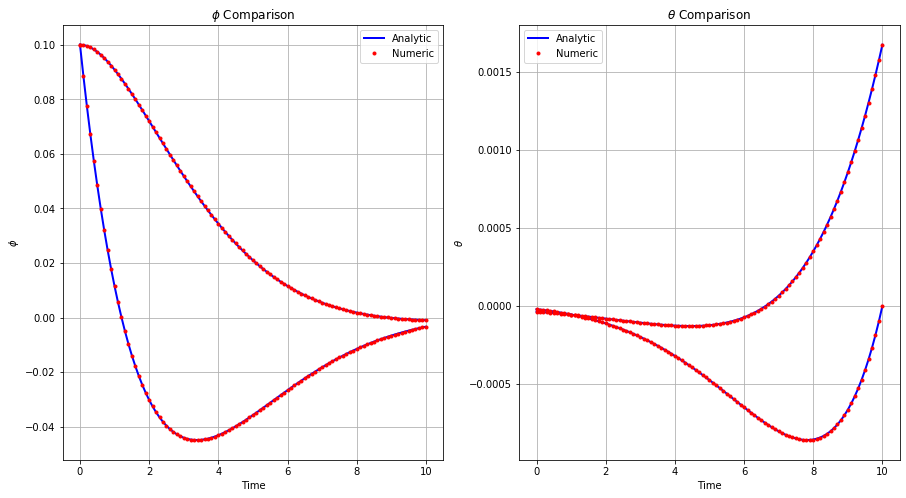

In [11]:
# Comparison Plot

fig, axes = plt.subplots(1, 2, figsize=(15, 8))
labels = ['$\\phi$', '$\\theta$']

# Phi Plot
axes[0].grid()
axes[0].set_title('$\\phi$ Comparison')
axes[0].plot(time, analytic_solution[:, 0], 'b', linewidth=2, label = 'Analytic')
axes[0].plot(time, analytic_solution[:, 1],'b', linewidth=2)
axes[0].plot(time, ham_alg.instanton[:, 0], 'r.', label = 'Numeric')
axes[0].plot(time, ham_alg.instanton[:, 1], 'r.')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('$\\phi$')
axes[0].legend()

# Theta Plot
axes[1].grid()
axes[1].set_title('$\\theta$ Comparison')
axes[1].plot(time, analytic_solution[:, 2], 'b', linewidth=2, label = 'Analytic')
axes[1].plot(time, analytic_solution[:, 3],'b', linewidth=2)
axes[1].plot(time, ham_alg.instanton[:, 2], 'r.', label = 'Numeric')
axes[1].plot(time, ham_alg.instanton[:, 3], 'r.')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('$\\theta$')
axes[1].legend()


fig.show()

## Checking Action has Been Minimised

In [12]:
# Defining utilitties for checking action being tracked.

def ou_a(t, x, p):
    "OU Drift"
    gamma, sigma = p
    return - gamma * x

class action_minimisation_checker:
    """Class for keeping track of instanton action comparisons."""
    
    def __init__(self, a, instanton, args):
        """ 
        param, a: Deterministic part of SDE, feeds in to action integral.
        param, instanton: the path we're comparing against
        param, args: arguments for a.
        """
        self.a = a
        self.p, self.dt = args
        
        # Instanton we will we check against
        self.instanton = instanton 
        self.action_value = self._action(instanton)
        
        self._compare_list = [(self.instanton, self.action_value)]
        self._smaller_list = []
        
    def _action(self, phi):
        """
        param, phi: is path we calculate action over    
        returns F-W action approximation where finite differences 
        are used to approximate the derivatives and integral.
        """
        v = np.gradient(phi, self.dt) -  self.a(0, phi, self.p)
        integrand =  v**2
        return 0.5 * np.trapz(integrand, dx=dt)
    
    def compare(self, path):
        """ Compare a provided path vs. the instanton.
        """
        x = self._action(path)
        self._add_comparison((path, x))
    
    @property
    def compared_paths(self):
        "Returns a list of tuples of compared paths and their action value"
        return self._compare_list
    
    def _add_comparison(self, path_tuple):
        self._compare_list.append(path_tuple)
        
    def any_smaller(self):
        "Checks if any compared path has a smaller action."
        for path_tuple in self.compared_paths:
            if (path_tuple[1] < self.action_value):
                print("Looks like a nearby path has a smaller action")
                self.add_smaller_path(path_tuple)
                print("I've made a note of this")
                return 
        print("Looks like it minimises")
        return
    @property
    def smaller_list(self):
        return self._smaller_list
    
    def add_smaller_path(self, x):
        self._smaller_list.append(x)
    
    def differences(self):
        "Prints differences in action for compared paths"
        for path_tuple in self.compared_paths:
            print(path_tuple[1] - self.action_value)

def eps_path(path, x):
    "Function that perturbs all non boundary points by x."
    ep = np.copy(path)
    ep[1:-1] += x
    return ep

### Comparing To Different Paths

We found in general it does minimise the aciton although there are some exceptions where it just about does not, see comments below.

In [13]:
instanton = ham_alg.phi_ts.flatten() #Why did you flatten this?

In [14]:
# comparison_paths = [eps_path(instanton, - (10**-x)) for x in range(8)] # Contains some smaller action paths
# comparison_paths = [eps_path(instanton, (10**-x)) for x in range(10)] # Instanton smaller than all here
# comparison_paths = [eps_path(instanton, 0.1 * x) for x in range(10)] # Instanton smaller than all here
# comparison_paths = [eps_path(instanton, 0.2 * x) for x in range(10)] # Instanton smaller than all here
# comparison_paths = [eps_path(instanton, -0.2 * x) for x in range(10)] # Instanton smaller than all here

In [15]:
action_track = action_minimisation_checker(ou_a, instanton, [p, dt])

ValueError: too many values to unpack (expected 2)

In [ ]:
for path in comparison_paths:
    action_track.compare(path)

In [ ]:
action_track.any_smaller()

In [ ]:
plt.plot(action_track.smaller_list[0][0])
plt.plot(instanton)